In [ ]:
!pip install imutils
!pip install imageio
from imutils.perspective import four_point_transform as FPT
from collections import Counter
import matplotlib.pyplot as plt
from imutils import contours
from skimage import io
import numpy as np
import imutils
import cv2
import re

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_image(url, iter = 2, width = None):
  image = io.imread(url)
  if width:
    image = imutils.resize(image, width)
  ans = image.copy()
  accumEdged = np.zeros(image.shape[:2], dtype="uint8")
  # convert image to black and white
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # blur to remove some of the noise
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # get edges
  edged = cv2.Canny(blurred, 75, 200)
  accumEdged = cv2.bitwise_or(accumEdged, edged)
  # get contours
  ctrs = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  ctrs = imutils.grab_contours(ctrs)
  docCnt = None

  # ensure that at least one contour was found
  if len(ctrs) > 0:
      # sort the contours according to their size in
      # descending order
      ctrs = sorted(ctrs, key=cv2.contourArea, reverse=True)

      # loop over the sorted contours
      for c in ctrs:
          # approximate the contour
          peri = cv2.arcLength(c, True)
          approx = cv2.approxPolyDP(c, 0.02 * peri, True)

          # if our approximated contour has four points,
          # then we can assume we have found the paper
          if len(approx) == 4:
              docCnt = approx
              break

  paper = image.copy()

  # apply Otsu's thresholding method to binarize the image
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  kernel = np.ones((5,5), np.uint8)
  # erode and dilate to remove some of the unnecessary detail
  thresh = cv2.erode(thresh, kernel, iterations = iter)
  thresh = cv2.dilate(thresh, kernel, iterations = iter)

  # find contours in the thresholded image
  ctrs = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  ctrs = imutils.grab_contours(ctrs)

  return image, ctrs, paper, gray, edged, thresh

# plot image without axes
def display(img):
  fig = plt.figure(figsize = (8,12))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
def get_image(url, iter = 2, width = None):
  image = io.imread(url)
  if width:
    image = imutils.resize(image, width)
  ans = image.copy()
  accumEdged = np.zeros(image.shape[:2], dtype="uint8")
  # convert image to black and white
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # blur to remove some of the noise
  blurred = cv2.GaussianBlur(gray, (5, 5), 0)
  # get edges
  edged = cv2.Canny(blurred, 75, 200)
  accumEdged = cv2.bitwise_or(accumEdged, edged)
  # get contours
  ctrs = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  ctrs = imutils.grab_contours(ctrs)
  docCnt = None

  # ensure that at least one contour was found
  if len(ctrs) > 0:
      # sort the contours according to their size in
      # descending order
      ctrs = sorted(ctrs, key=cv2.contourArea, reverse=True)

      # loop over the sorted contours
      for c in ctrs:
          # approximate the contour
          peri = cv2.arcLength(c, True)
          approx = cv2.approxPolyDP(c, 0.02 * peri, True)

          # if our approximated contour has four points,
          # then we can assume we have found the paper
          if len(approx) == 4:
              docCnt = approx
              break

  paper = image.copy()

  # apply Otsu's thresholding method to binarize the image
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  kernel = np.ones((5,5), np.uint8)
  # erode and dilate to remove some of the unnecessary detail
  thresh = cv2.erode(thresh, kernel, iterations = iter)
  thresh = cv2.dilate(thresh, kernel, iterations = iter)

  # find contours in the thresholded image
  ctrs = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  ctrs = imutils.grab_contours(ctrs)

  return image, ctrs, paper, gray, edged, thresh

# plot image without axes
def display(img):
  fig = plt.figure(figsize = (8,12))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

In [ ]:
def sort_contours(ctrs):
  BB = [list(cv2.boundingRect(c)) for c in ctrs]
  # choose tolerance for x, y coordinates of the bounding boxes to be binned together
  tol = 0.7*diam

  # change x and y coordinates of bounding boxes to their corresponding bins
  def sort(i):
    S = sorted(BB, key = lambda x: x[i])
    s = [b[i] for b in S]
    m = s[0]

    for b in S:
      if m - tol < b[i] < m or m < b[i] < m + tol:
        b[i] = m
      elif b[i] > m + diam:
        for e in s[s.index(m):]:
          if e > m + diam:
            m = e
            break
    return sorted(set(s))

  # lists of of x and y coordinates
  xs = sort(0)
  ys = sort(1)

  (ctrs, BB) = zip(*sorted(zip(ctrs, BB), key = lambda b: b[1][1]*len(image) + b[1][0]))
  # return the list of sorted contours and bounding boxes
  return ctrs, BB, xs, ys

def get_circles():
  questionCtrs = []
  for c in ctrs:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w / float(h)

    # in order to label the contour as a question, region
    # should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
  #     if w >= 20 and h >= 20 and 0.9 <= ar <= 1.1:
    if diam*0.8 <= w <= diam*1.2 and 0.8 <= ar <= 1.2:
      questionCtrs.append(c)
  return questionCtrs

def get_diameter():
  boundingBoxes = [list(cv2.boundingRect(c)) for c in ctrs]
  c = Counter([i[2] for i in boundingBoxes])
  mode = c.most_common(1)[0][0]
  if mode > 1:
    diam = mode
  else:
    diam = c.most_common(2)[1][0]
  return diam


def draw_contours(questionCtrs):
  color = (0, 255, 0)
  i = 0
  for q in range(len(questionCtrs)):
    cv2.drawContours(paper, questionCtrs[q], -1, color, 3)
    cv2.putText(paper, str(i), (boundingBoxes[q][0] + boundingBoxes[q][2]//2, boundingBoxes[q][1] + boundingBoxes[q][3]//2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    i += 1


In [ ]:
def get_spacing():

  def spacing(x):
    space = []
    coor = [b[x] for b in boundingBoxes]
    for i in range(len(coor)-1):
      c = coor[i+1] - coor[i]
      if c > diam//2: space.append(c)
    return sorted(list(set(space)))

  spacingX = spacing(0)
  spacingY = spacing(1)

  # smallest x-serapation (between two adjacent dots in a letter)
  m = min(spacingX)

  c = 0

  d1 = spacingX[0]
  d2 = 0
  d3 = 0

#   for x in range(len(spacingX)):
#     if spacingX[x+1] > spacingX[x]*1.1:
#       c += 1
#       if d2 == 0: d2 = spacingX[x+1]
#     if c == 2:
#       d3 = spacingX[x+1]
#       break

  for x in spacingX:
    if d2 == 0 and x > d1*1.3:
      d2 = x
    if d2 > 0 and x > d2*1.3:
      d3 = x
      break

  linesV = []
  prev = 0 # outside

  linesV.append(min(xs) - (d2 - diam)/2)

  for i in range(1, len(xs)):
    diff = xs[i] - xs[i-1]
    if i == 1 and d2*0.9 < diff:
      linesV.append(min(xs) - d2 - diam/2)
      prev = 1
    if d1*0.8 < diff < d1*1.2:
      linesV.append(xs[i-1] + diam + (d1 - diam)/2)
      prev = 1
    elif d2*0.8 < diff < d2*1.1:
      linesV.append(xs[i-1] + diam + (d2 - diam)/2)
      prev = 0
    elif d3*0.9 < diff < d3*1.1:
      if prev == 1:
        linesV.append(xs[i-1] + diam + (d2 - diam)/2)
        linesV.append(xs[i-1] + d2 + diam + (d1 - diam)/2)
      else:
        linesV.append(xs[i-1] + diam + (d1 - diam)/2)
        linesV.append(xs[i-1] + d1 + diam + (d2 - diam)/2)
    elif d3*1.1 < diff:
      if prev == 1:
        linesV.append(xs[i-1] + diam + (d2 - diam)/2)
        linesV.append(xs[i-1] + d2 + diam + (d1 - diam)/2)
        linesV.append(xs[i-1] + d3 + diam + (d2 - diam)/2)
#         if d2 + d3 < diff:
#           linesV.append(xs[i-1] + 2*d3 - (d2 - diam)/2)
        prev = 0
      else:
        linesV.append(xs[i-1] + diam + (d1 - diam)/2)
        linesV.append(xs[i-1] + d1 + diam + (d2 - diam)/2)
        linesV.append(xs[i-1] + d1 + d2 + diam + (d1 - diam)/2)
        linesV.append(xs[i-1] + d1 + d3 + diam + (d2 - diam)/2)
#         if d2 + d3 < diff:
#           linesV.append(xs[i-1] + d1 + 2*d3 - (d2 - diam)/2)
        prev = 1

  linesV.append(max(xs) + diam*1.5)
  if len(linesV)%2 == 0:
    linesV.append(max(xs) + d2 + diam)

  return linesV, d1, d2, d3, spacingX, spacingY


def display_contours(figsize = (15,30), lines = False):

  fig = plt.figure(figsize = figsize)
  plt.rcParams['axes.grid'] = False
  plt.rcParams['axes.spines.left'] = False
  plt.axis('off')
  plt.imshow(paper)
  if lines:
    for x in linesV:
      plt.axvline(x)

  plt.show()

In [ ]:
def get_letters(showID = False):

  Bxs = list(boundingBoxes)
  Bxs.append((100000, 0))

  dots = [[]]
  for y in sorted(list(set(spacingY))):
    if y > 1.3*diam:
      minYD = y*1.5
      break

  # get lines of dots
  for b in range(len(Bxs)-1):
    if Bxs[b][0] < Bxs[b+1][0]:
        if showID: dots[-1].append((b, Bxs[b][0:2]))
        else: dots[-1].append(Bxs[b][0])
    else:
      if abs(Bxs[b+1][1] - Bxs[b][1]) < minYD:
        if showID: dots[-1].append((b, Bxs[b][0:2]))
        else: dots[-1].append(Bxs[b][0])
        dots.append([])
      else:
        if showID: dots[-1].append((b, Bxs[b][0:2]))
        else: dots[-1].append(Bxs[b][0])
        dots.append([])
        if len(dots)%3 == 0 and not dots[-1]:
          dots.append([])

#   for d in dots: print(d)

  letters = []

  count = 0

  for r in range(len(dots)):
    if not dots[r]:
      letters.append([0 for _ in range(len(linesV)-1)])
      continue

    else:
      letters.append([])
      c = 0
      i = 0
      while i < len(linesV)-1:
        if c < len(dots[r]):
          if linesV[i] < dots[r][c] < linesV[i+1]:
            letters[-1].append(1)
            c += 1
          else:
            letters[-1].append(0)
        else:
          letters[-1].append(0)
        i += 1

  #   print(letters[-1])
  for l in range(len(letters)):
    if l%3 == 0: print()
    print(letters[l])
  print()

  return letters

In [ ]:
import numpy as np
import re

def translate(letters):
    alpha = {'a': '1', 'b': '13', 'c': '12', 'd': '124', 'e': '14', 'f': '123',
             'g': '1234', 'h': '134', 'i': '23', 'j': '234', 'k': '15',
             'l': '135', 'm': '125', 'n': '1245', 'o': '145', 'p': '1235',
             'q': '12345', 'r': '1345', 's': '235', 't': '2345', 'u': '156',
             'v': '1356', 'w': '2346', 'x': '1256', 'y': '12456', 'z': '1456',
             '#': '2456', '^': '6', ',': '3', '.': '346', '\"': '356', '^': '26',
             ':': '34', '\'': '5'}

    nums = {'a': '1', 'b': '2', 'c': '3', 'd': '4', 'e': '5', 'f': '6', 'g': '7', 'h': '8', 'i': '9', 'j': '0'}

    braille = {v: k for k, v in alpha.items()}

    letters = np.array([np.array(l) for l in letters])

    ans  = ''

    for r in range(0, len(letters), 3):
        for c in range(0, len(letters[0]), 2):
            f = letters[r:r+3, c:c+2].flatten()
            f = ''.join([str(i + 1) for i, d in enumerate(f) if d == 1])
            if f == '6': f = '26'
            if not f:
                if ans and ans[-1] != ' ': ans += ' '
            elif f in braille:
                ans += braille[f]
            else:
                ans += '?'
        if ans and ans[-1] != ' ': ans += ' '

    # Replace numbers
    def replace_nums(m):
        return nums.get(m.group('key'), m.group(0))
    ans = re.sub(r'#(?P<key>[a-zA-Z])', replace_nums, ans)

    # Capitalize
    def capitalize(m):
        return m.group(0)[1].upper()
    ans = re.sub(r'\^(?P<key>[a-zA-Z])', capitalize, ans)

    return ans


In [ ]:
# url = 'https://i.imgur.com/NwLqmz2.jpg'    # works
# url = 'https://i.imgur.com/4nC067a.jpg'    # works
# url = 'https://i.imgur.com/osNCAx3.jpg'    # works
# url = 'https://i.imgur.com/maU4r0t.jpg'    # works
# url = 'https://i.imgur.com/OdyYxp1.jpg'    # not works :< (because letters aren't aligned vertically)
# url = 'https://i.imgur.com/ttq5PzE.jpg'    # works
# url = 'https://i.imgur.com/EjBz4nI.jpg'    # works (iter = 0, width = 1500)
# url = 'https://i.imgur.com/4ggIni9.jpg'    # not works :<
# url = 'https://i.imgur.com/UBqs60s.jpg'    # works
# url = 'https://i.imgur.com/ihU7tFt.jpg'    # works (iter = 0, width = 1500)
from google.colab import files
uploaded = files.upload()  # Opens a dialog to upload a file

    # Retrieve the uploaded file path
url = next(iter(uploaded))    # works (iter = 0, width = 1500)

image, ctrs, paper, gray, edged, thresh = get_image(url, iter = 0, width = 1500)


diam = get_diameter()
dotCtrs = get_circles()

questionCtrs, boundingBoxes, xs, ys = sort_contours(dotCtrs)
draw_contours(questionCtrs)

linesV, d1, d2, d3, spacingX, spacingY = get_spacing()

letters = get_letters()
ans = translate(letters)

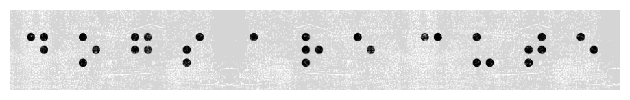

dogs??i,cute


In [ ]:
from textwrap import wrap

plt.axis('off')
io.imshow(image)
plt.show()
for l in wrap(ans, width = 80):
  print(l)

In [ ]:
pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.8 MB/s eta 0:00:00


In [ ]:
!pip install language_tool_python




In [ ]:
from spellchecker import SpellChecker
import language_tool_python

# Initialize the spell checker
spell = SpellChecker()

# Initialize the language tool for grammar correction
tool = language_tool_python.LanguageTool('en-US')

INFO:language_tool_python.download_lt:Unzipping /tmp/tmp5ad4x7zo.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.


In [ ]:
# Function to remove special characters
text=ans
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', ' ', text)  # Remove all non-alphanumeric characters except spaces

# Function to correct spelling
def correct_spelling(text):
    words = text.split()  # Split sentence into words
    corrected_words = []
    for word in words:
        corrected = spell.correction(word)
        if corrected is None:  # If no correction, use the original word
            corrected_words.append(word)
        else:
            corrected_words.append(corrected)
    return ' '.join(corrected_words)

# Function to correct grammar
def correct_grammar(text):
    matches = tool.check(text)  # Check the text for grammar mistakes
    corrected_text = language_tool_python.utils.correct(text, matches)  # Get the corrected sentence
    return corrected_text

# Function to process text by removing special characters, correcting spelling, and grammar

text = remove_special_characters(text)        # Step 1: Remove special characters
print(text)
text = correct_spelling(text)                 # Step 2: Correct spelling
print(text)
text = correct_grammar(text)                  # Step 3: Correct grammar

print(text)

dogs  i cute 
dogs i cute
Dogs i cute


In [ ]:
pip install transformers

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

def correct_grammar(text):
    model_name = "vennify/t5-base-grammar-correction"
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Prepare the text for the T5 model
    input_text = f"grammar: {text}"
    inputs = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)

    # Generate the corrected sentence
    outputs = model.generate(inputs, max_length=512, num_beams=5, early_stopping=True)
    corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return corrected_sentence

# Example usage
input_text =  text
corrected_text = correct_grammar(input_text)
print(corrected_text)